# Model-based behaviors

In this notebook we measure the performance of 4 model-based navigation behaviors:

`Dummy`: which ignores the pad and the other agent.

In [1]:
from navground import sim, core
from navground.sim.ui.video import display_video
from navground.learning.behaviors.pad import DistributedPadBehavior, CentralizedPadBehavior, StopAtPadBehavior
from navground.learning.scenarios.pad import PadScenario, render_kwargs

scenario = sim.load_scenario("""
type: Pad
start_in_opposite_sides: true
groups:
  - number: 2
    behavior:
      type: Dummy
""")

world = scenario.make_world(seed=2)
display_video(world, time_step=0.1, duration=10, factor=4, **render_kwargs())

`StopAtPad`, which stop nearby the pad without crossing it.

In [2]:
scenario = sim.load_scenario("""
type: Pad
start_in_opposite_sides: true
groups:
  - number: 2
    behavior:
      type: StopAtPad
""")

world = scenario.make_world(seed=2)
display_video(world, time_step=0.1, duration=10, factor=4, **render_kwargs())

`Pad`, a distributed behavior that tries to solve the problem optimally by tuning the speed to avoid conflicts and gives precedence to the other agent if it would exit first from the pad. The agent does not know the other agent desired speed, which it infer from its current speed.

In [3]:
scenario = sim.load_scenario("""
type: Pad
start_in_opposite_sides: true
groups:
  - number: 2
    behavior:
      type: Pad
    state_estimation:
      type: Bounded
      range: 10
""")

world = scenario.make_world(seed=2)
display_video(world, time_step=0.1, duration=10, factor=4, **render_kwargs())

`CentralizedPad`, a *centralized* behavior which is similar to `Pad` but knows everything about both agents and control them at the same time.

In [4]:
from navground import sim
from navground.sim.ui.video import display_video

scenario = sim.load_scenario("""
type: Pad
start_in_opposite_sides: true
groups:
  - number: 2
    behavior:
      type: CentralizedPad
""")

world = scenario.make_world(seed=2)
world._prepare()
video = display_video(world, time_step=0.1, duration=10, factor=4, **render_kwargs())
world._close()
video

## Reward starting from opposing sides

We compute the reward distribution when the agents start from oppositing sides of the map.
The reward function is composed by two terms:
- `1 - efficacy` (i.e., 0 if moving forwards at full desired speed)
- `pad_penality` when two agents are on the pad at the same time.

here, we compute the reward for `pad_penality=1`, which we will later use to pick a penality that balance the tendency to stop and cross the pad. 

In [5]:
from navground.learning.examples.pad import PadReward

reward = PadReward(pad_penality=1)

In [6]:
from navground.learning.probes import RewardProbe
from navground.learning.probes.success import SuccessProbe
from navground.learning.examples.pad import is_success, is_failure

scenario = sim.load_scenario("""
type: Pad
groups:
  - number: 
      sampler: sequence
      values: [2, 0, 0]
      once: true
    behavior:
      type: Pad
    state_estimation:
      type: Bounded
      range: 10
  - number: 
      sampler: sequence
      values: [0, 2, 0]
      once: true
    behavior:
      type: StopAtPad
  - number: 
      sampler: sequence
      values: [0, 0, 2]
      once: true
    behavior:
      type: Dummy
start_in_opposite_sides: true
""")

exp = sim.Experiment(time_step=0.1, steps=200)
exp.scenario = scenario
exp.add_record_probe("reward", RewardProbe.with_reward(reward=reward))
exp.add_record_probe("success", SuccessProbe.with_criteria(is_success=is_success, is_failure=is_failure))
exp.terminate_when_all_idle_or_stuck = False

We perform 2000 runs for each behavior, which is shared by the two agents.

In [7]:
exp.run(number_of_runs=6 * 1000)

In [11]:
import numpy as np
import pandas as pd

rewards = np.asarray([np.sum(run.records['reward']) / 2 for run in exp.runs.values()]).reshape(-1, 3)
success = np.asarray([np.mean(np.asarray(run.records['success']) > 0) for run in exp.runs.values()]).reshape(-1, 3)
steps = np.asarray([run.recorded_steps for run in exp.runs.values()]).reshape(-1, 3)

df = pd.DataFrame()
for i, name in enumerate(('Pad', 'Stop', 'Dummy')):
    df[name] = {'reward mean': np.mean(rewards[:, i]), 
                'reward std': np.std(rewards[:, i]),
                'success rate': np.mean(success[:, i]),
                'length mean': np.mean(steps[:, i]), 
                'length std': np.std(steps[:, i])}

df.to_csv('behaviors.csv')

In [12]:
pd.set_option("display.precision", 2)
df.T

reward mean  reward std  success rate  length mean  length std
Pad         -10.47        5.80          1.00       145.65       11.81
Stop       -172.76       10.71          0.00       200.00        0.00
Dummy       -19.77       11.46          0.14       126.53       12.63

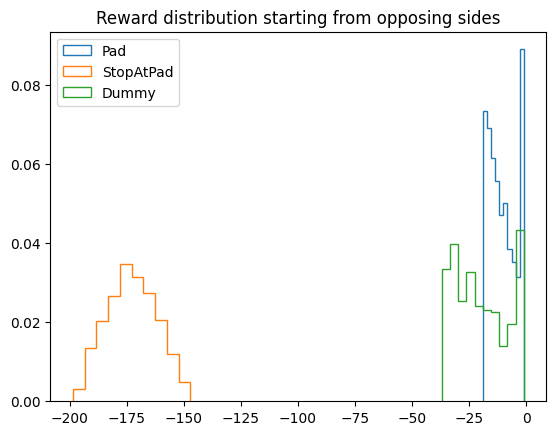

In [13]:
from matplotlib import pyplot as plt

for rs, name in zip(rewards.T, ('Pad', 'StopAtPad', 'Dummy')):
    plt.hist(rs, density=True, label=name, histtype='step')
plt.title("Reward distribution starting from opposing sides")
plt.legend();

In [14]:
easy = rewards[:, -1] >= -1.1
easy_prob = np.sum(easy, axis=0) / len(easy)
print(f'about {easy_prob:.0%} of the cases requires no coordination')

about 11% of the cases requires no coordination


Penality for efficiency should make `Dummy` and `StopAtPad` almost even:

In [15]:
ms = np.mean(rewards, axis=0)
print(f'Penality: {round(ms[1] / ms[2], 2)}')

Penality: 8.74


## Reward starting uniformly along the corridor

We also compute the reward distribution when the agents start uniformly along the corridor.

In [16]:
scenario = sim.load_scenario("""
type: Pad
groups:
  - number: 
      sampler: sequence
      values: [2, 0, 0]
      once: true
    behavior:
      type: Pad
    state_estimation:
      type: Bounded
      range: 10
  - number: 
      sampler: sequence
      values: [0, 2, 0]
      once: true
    behavior:
      type: StopAtPad
  - number: 
      sampler: sequence
      values: [0, 0, 2]
      once: true
    behavior:
      type: Dummy
start_in_opposite_sides: false
""")

exp = sim.Experiment(time_step=0.1, steps=200)
exp.scenario = scenario
exp.add_record_probe("reward", RewardProbe.with_reward(reward=reward))
exp.add_record_probe("success", SuccessProbe.with_criteria(is_success=is_success, is_failure=is_failure))
exp.terminate_when_all_idle_or_stuck = False

In [17]:
exp.run(number_of_runs=6 * 1000)

In [18]:
rewards = np.asarray([np.sum(run.records['reward']) / 2 for run in exp.runs.values()]).reshape(-1, 3)
success = np.asarray([np.mean(np.asarray(run.records['success']) > 0) for run in exp.runs.values()]).reshape(-1, 3)
steps = np.asarray([run.recorded_steps for run in exp.runs.values()]).reshape(-1, 3)

df = pd.DataFrame()
for i, name in enumerate(('Pad', 'Stop', 'Dummy')):
    df[name] = {'reward mean': np.mean(rewards[:, i]), 
                'reward std': np.std(rewards[:, i]),
                'success rate': np.mean(success[:, i]),
                'length mean': np.mean(steps[:, i]), 
                'length std': np.std(steps[:, i])}

df.to_csv('behaviors_same_side.csv')

In [19]:
pd.set_option("display.precision", 2)
df.T

reward mean  reward std  success rate  length mean  length std
Pad       -3.81776     5.53239       0.94150      101.324    37.04168
Stop     -66.44618    58.58046       0.56125      145.944    68.60380
Dummy     -5.12508     8.65664       0.76000       96.188    34.11926

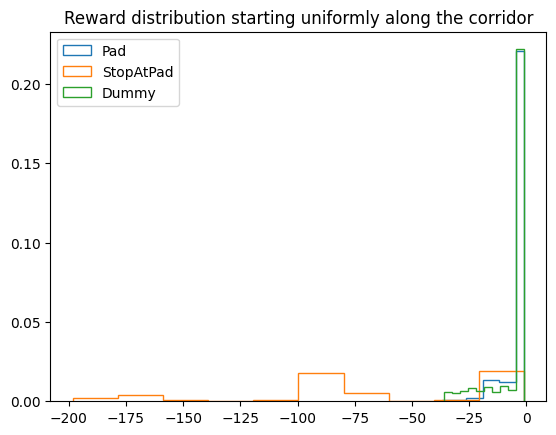

In [20]:
for rs, name in zip(rewards.T, ('Pad', 'StopAtPad', 'Dummy')):
    plt.hist(rs, density=True, label=name, histtype='step')
plt.title("Reward distribution starting uniformly along the corridor")
plt.legend();

In [21]:
easy = rewards[:, -1] >= -1.1
easy_prob = np.sum(easy, axis=0) / len(easy)
print(f'about {easy_prob:.0%} of the cases requires no coordination')

about 75% of the cases requires no coordination


Penality for efficiency should make `Dummy` and `StopAtPad` almost even:

In [22]:
ms = np.mean(rewards, axis=0)
print(f'Penality: {round(ms[1] / ms[2], 2)}')

Penality: 12.96
